In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.tsa.api as smt
import seaborn as sns
import numpy as np
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.dates as mdates
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder,OneHotEncoder
sns.set(rc={'figure.figsize':(11, 4)})

read data and keep the data from Dec,31 2012.

,Energy_Generated,Efficiency,Energy_Exported,Energy_Used,Peak_Power,Peak_Time,Condition,Min_Temperature,Max_Temperature,Peak_Energy_Import,Off-Peak_Energy_Import,Shoulder_Energy_Import,High-Shoulder_Energy_Import,Insolation
Date,,,,,,,,,,,,,,
2020-02-03,3321,3.075,2910,0,646.0,13:40,Fine,6.0,29.0,NaN,NaN,NaN,NaN,4048
2020-02-04,1611,1.492,1275,0,678.0,14:30,Mostly Cloudy,8.0,16.0,NaN,NaN,NaN,NaN,4084
2020-02-05,4140,3.833,2816,0,737.0,12:40,Fine,0.0,16.0,NaN,NaN,NaN,NaN,4121
2020-02-06,4241,3.927,3585,0,740.0,13:00,Fine,-2.0,20.0,NaN,NaN,NaN,NaN,4157
2020-02-07,2654,2.457,2337,0,740.0,13:00,Fine,0.0,21.0,NaN,NaN,NaN,NaN,4194


2541


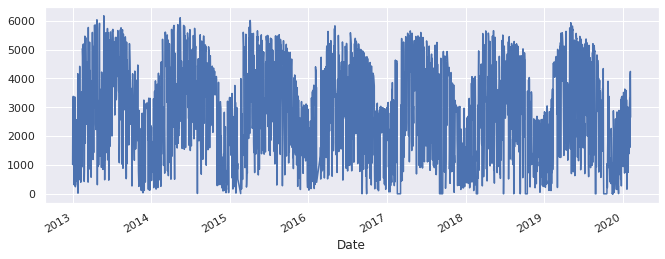

In [2]:
data = pd.read_pickle("../DATA_COLLECTOR/AGGREGATION_PRODUCTION/aggreg_PRODUCTION_data.pkl")
#data = pd.read_csv("../DATA_COLLECTOR/AGGREGATION_PRODUCTION/aggreg_PRODUCTION_data.csv")
data.Date = pd.to_datetime(data['Date'],format='%Y%m%d')
data = data.sort_values(by='Date')
data = data[data.Date > '2012-12-31']
data = data.set_index('Date')

display(data.tail())
print(len(data))


data.Energy_Generated = pd.to_numeric(data.Energy_Generated)
data.Energy_Generated.plot()

Split data into train and test

In [3]:
thresh_date = '2018-12-31' #'2019-02-07', '2019-08-31'
train_data = data[data.index < thresh_date]
test_data = data[data.index > thresh_date]
display(train_data.head(2))
display(test_data.head(2))

print("Train size %d, test size %d" % (len(train_data), len(test_data)))

,Energy_Generated,Efficiency,Energy_Exported,Energy_Used,Peak_Power,Peak_Time,Condition,Min_Temperature,Max_Temperature,Peak_Energy_Import,Off-Peak_Energy_Import,Shoulder_Energy_Import,High-Shoulder_Energy_Import,Insolation
Date,,,,,,,,,,,,,,
2013-01-01,1013,0.938,998,0,807.0,13:10,Showers,8.0,13.0,NaN,NaN,NaN,NaN,3458
2013-01-02,2878,2.665,2840,0,837.0,13:00,Mostly Cloudy,7.0,13.0,NaN,NaN,NaN,NaN,3472


,Energy_Generated,Efficiency,Energy_Exported,Energy_Used,Peak_Power,Peak_Time,Condition,Min_Temperature,Max_Temperature,Peak_Energy_Import,Off-Peak_Energy_Import,Shoulder_Energy_Import,High-Shoulder_Energy_Import,Insolation
Date,,,,,,,,,,,,,,
2019-01-01,2022,1.872,1637,0,744.0,13:05,Fine,-2.0,9.0,NaN,NaN,NaN,NaN,3243
2019-01-02,277,0.256,88,0,116.0,14:40,Showers,2.0,4.0,NaN,NaN,NaN,NaN,3255


Train size 2139, test size 401


get daily production from MA with a window of 28 day ; resample the data weekly,monthly

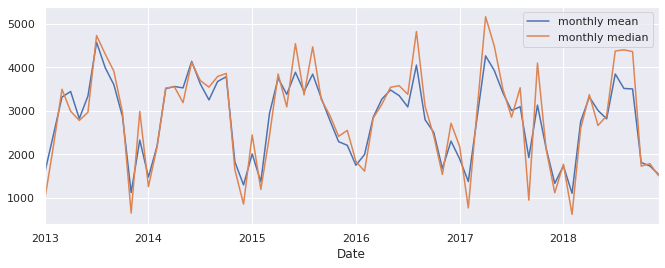

In [4]:
monthly_data_mean = train_data.Energy_Generated.resample('M').mean()
monthly_data_median = train_data.Energy_Generated.resample('M').median()
monthly_data_mean.plot(label='monthly mean')
monthly_data_median.plot(label='monthly median')
plt.legend()

weekly_data_mean = train_data.Energy_Generated.resample('W').mean()

Text(0.5, 1.0, 'Trends in Generated Energy')

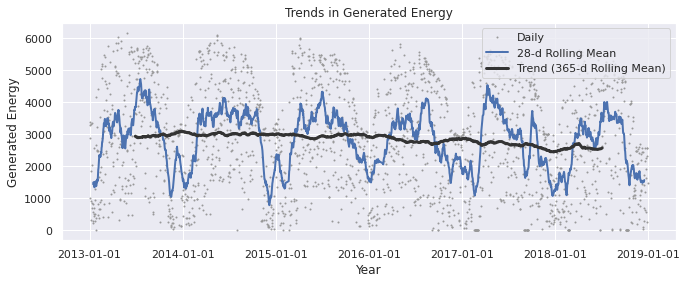

In [5]:
rolling_data_28day = train_data.Energy_Generated.rolling(28, center=True).mean()
rolling_data_365day = train_data.Energy_Generated.rolling(window=365, center=True, min_periods=360).mean()
rolling_data_28day = rolling_data_28day.dropna()


# Plot daily, 28-day rolling mean, and 365-day rolling mean time series
fig, ax = plt.subplots()
ax.plot(train_data.Energy_Generated, marker='.', markersize=2, color='0.6',
linestyle='None', label='Daily')
ax.plot(rolling_data_28day, linewidth=2, label='28-d Rolling Mean')
ax.plot(rolling_data_365day, color='0.2', linewidth=3,
label='Trend (365-d Rolling Mean)')
# Set x-ticks to yearly interval and add legend and labels
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.legend()
ax.set_xlabel('Year')
ax.set_ylabel('Generated Energy')
ax.set_title('Trends in Generated Energy')

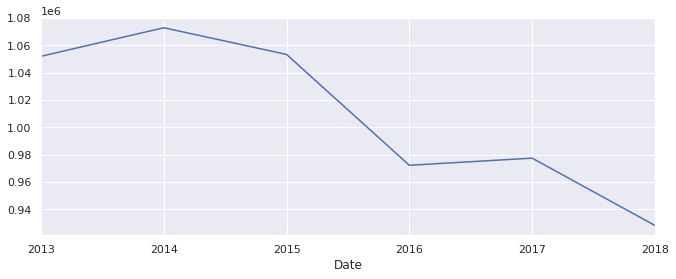

In [6]:
annual_data_sum = train_data.Energy_Generated.resample('A').sum()
annual_data_sum.plot()

<Figure size 792x288 with 0 Axes>

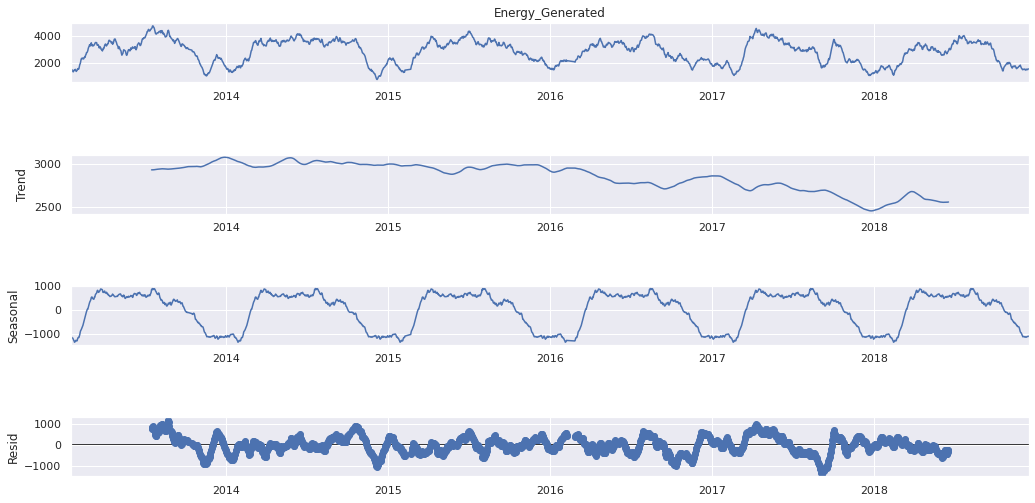

In [7]:
decomposition = seasonal_decompose(rolling_data_28day,period=360) 
fig = plt.figure()  
fig = decomposition.plot()  
fig.set_size_inches(15, 8)

<Figure size 792x288 with 0 Axes>

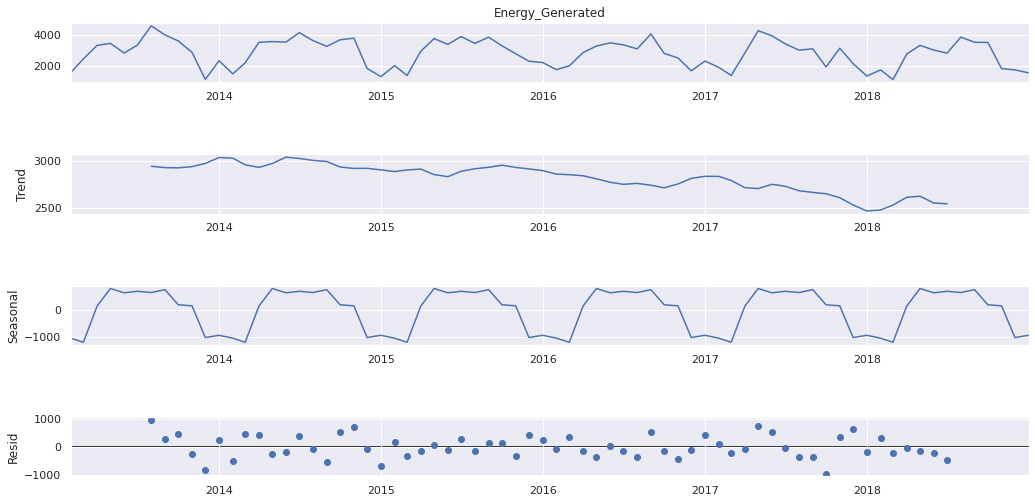

In [8]:
decomposition = seasonal_decompose(monthly_data_mean,period=12) 
fig = plt.figure()  
fig = decomposition.plot()  
fig.set_size_inches(15, 8)

<Figure size 792x288 with 0 Axes>

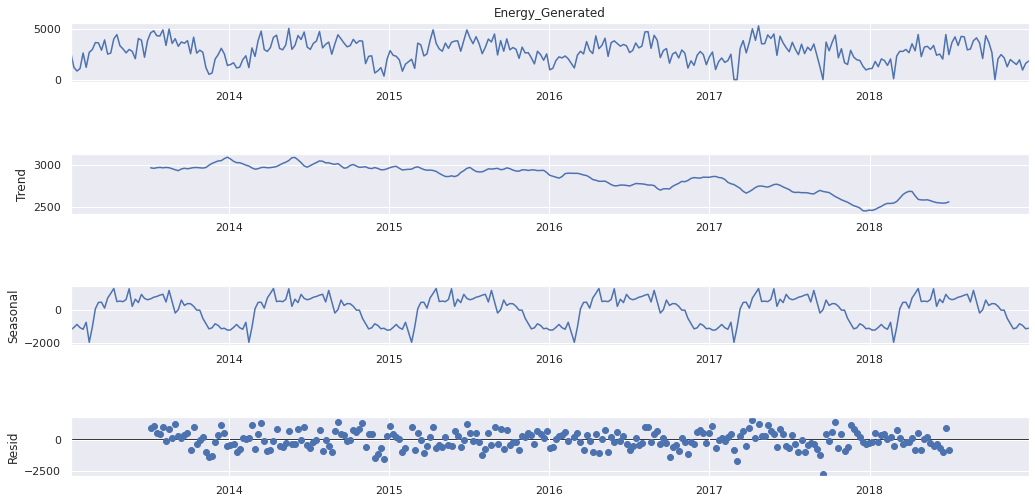

In [9]:
weekly_data_mean = weekly_data_mean.dropna()
decomposition = seasonal_decompose(weekly_data_mean,period=52) 
fig = plt.figure()  
fig = decomposition.plot()  
fig.set_size_inches(15, 8)

SARIMA on weekly mean production and monthly mean production

In [10]:
from statsmodels.tsa.stattools import adfuller

def test_stationarity(timeseries):  
    #Determing rolling statistics
    rolmean = timeseries.rolling(12, center=True).mean()
    rolstd = timeseries.rolling(12).std()

    #Plot rolling statistics:
    fig  = plt.figure(figsize=(12, 8))
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std  = plt.plot(rolstd, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

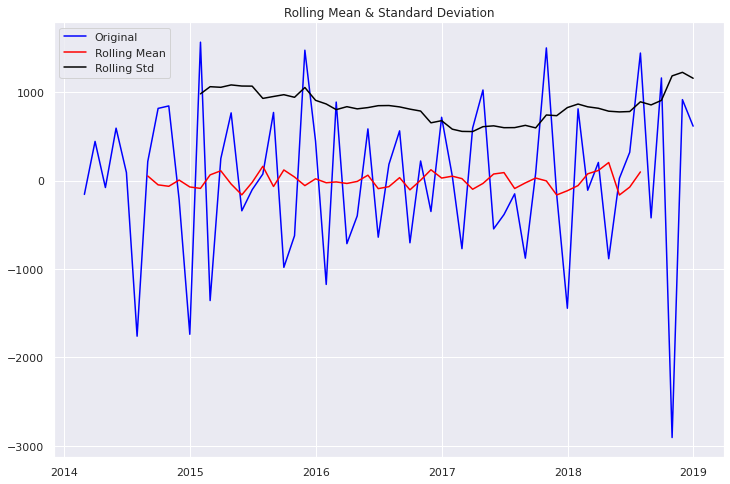

Results of Dickey-Fuller Test:
Test Statistic                -6.572223e+00
p-value                        7.883918e-09
#Lags Used                     4.000000e+00
Number of Observations Used    5.400000e+01
Critical Value (1%)           -3.557709e+00
Critical Value (5%)           -2.916770e+00
Critical Value (10%)          -2.596222e+00
dtype: float64


In [11]:
monthly_data_mean_first_diff = monthly_data_mean - monthly_data_mean.shift(1)  
monthly_data_mean_seasonal_first_difference = monthly_data_mean_first_diff - monthly_data_mean_first_diff.shift(12)
test_stationarity(monthly_data_mean_seasonal_first_difference.dropna(inplace=False))

Autocorrelation study to check the s,p,d,q order

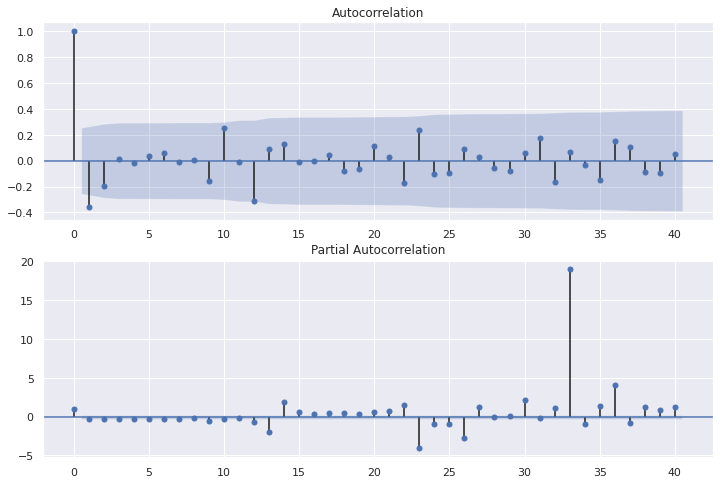

In [12]:
import statsmodels.api as sm 

fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(monthly_data_mean_seasonal_first_difference.iloc[13:], lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(monthly_data_mean_seasonal_first_difference.iloc[13:], lags=40, ax=ax2)

In [13]:
mod = sm.tsa.statespace.SARIMAX(monthly_data_mean, trend='n', order=(0,1,2), seasonal_order=(0,1,2,12))
results = mod.fit()
print(results.summary())

SARIMAX Results                                      
Dep. Variable:                   Energy_Generated   No. Observations:                   72
Model:             SARIMAX(0, 1, 2)x(0, 1, 2, 12)   Log Likelihood                -455.328
Date:                            Tue, 31 Mar 2020   AIC                            920.657
Time:                                    22:23:57   BIC                            931.044
Sample:                                01-31-2013   HQIC                           924.712
                                     - 12-31-2018                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.9909      0.284     -3.494      0.000      -1.547      -0.435
ma.L2         -0.0087      0.143     -0.061      0.951      -0.290      

Residual analyse

count      72.000000
mean      -58.946388
std       670.907798
min     -1946.852573
25%      -533.600962
50%       -16.486492
75%       395.023178
max      1567.161290
dtype: float64


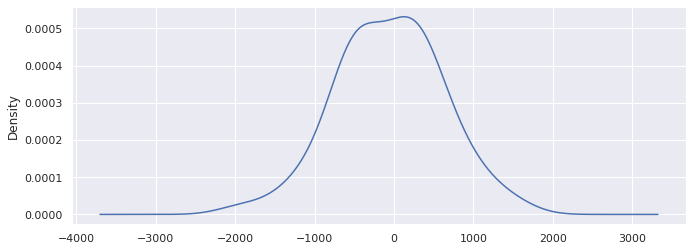

In [14]:
residuals = results.resid
#residuals.plot()
residuals.plot(kind='kde')
print(residuals.describe())

prediction for monthly data

In [15]:
test_monthly_data_mean = test_data.Energy_Generated.resample('M').mean()
M_test_size = len(test_monthly_data_mean)
print(M_test_size)

14


2019-01-31    1541.607003
2019-02-28    1379.976021
2019-03-31    2698.849888
2019-04-30    3414.276203
2019-05-31    3206.028706
2019-06-30    3175.747929
2019-07-31    3212.547893
2019-08-31    3326.221623
2019-09-30    2700.607269
2019-10-31    2483.609583
2019-11-30    1636.060565
2019-12-31    1508.692406
2020-01-31    1477.491314
2020-02-29    1251.121349
2020-03-31    2613.464897
Freq: M, dtype: float64


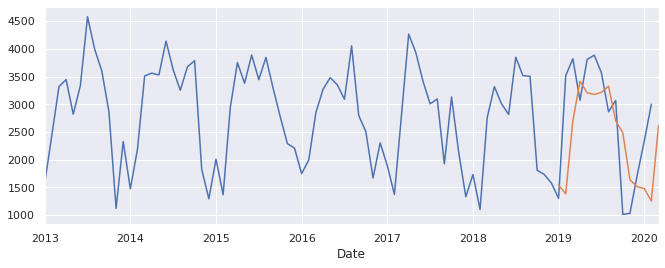

In [16]:
end   = M_test_size + monthly_data_mean.shape[0]
start = monthly_data_mean.shape[0]
forecast_values = results.predict(start=start, end=end, dynamic=True)
all_monthly_data_mean = data.Energy_Generated.resample('M').mean()
all_monthly_data_mean.plot()
forecast_values.plot()

print(forecast_values)

LSTM 

In [17]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

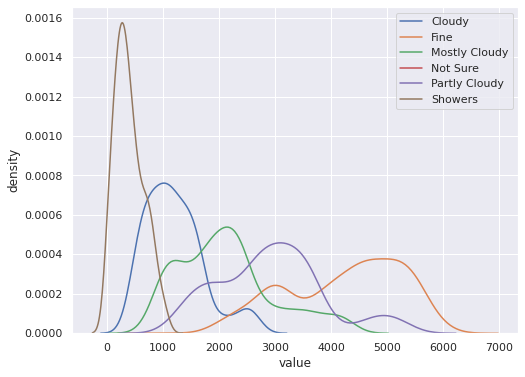

In [18]:
conditions = data.Condition.values
fig, ax = plt.subplots(figsize=(8,6))
for label in np.unique(conditions):
    # this is to plot the kde
    try:
        sns.kdeplot(data.Energy_Generated[data.Condition == label],label=label)
    except:
        print(label)
plt.xlabel('value')
plt.ylabel('density')
plt.show()

In [19]:
features = ['Condition','Energy_Generated']
daily_data_with_weather = data[features]
conditions = set(daily_data_with_weather['Condition'])

encoder = LabelEncoder()
daily_data_with_weather.Condition = encoder.fit_transform(daily_data_with_weather.Condition)
conditions_labels = set(daily_data_with_weather['Condition'])

le_name_mapping = dict(zip(encoder.classes_, encoder.transform(encoder.classes_)))
print(le_name_mapping)

daily_data_with_weather = daily_data_with_weather[daily_data_with_weather.Condition != 3]


train_size = int(len(daily_data_with_weather) * 0.8)
test_size = len(daily_data_with_weather) - train_size
print(train_size,test_size)
# ensure all data is float
daily_data_with_weather = daily_data_with_weather.astype('float32')

daily_data_with_weather = daily_data_with_weather.dropna()
cols = daily_data_with_weather.columns.tolist()

# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaler.fit(daily_data_with_weather.iloc[:train_size])
scaled = scaler.transform(daily_data_with_weather)

target_scaler = MinMaxScaler(feature_range=(0, 1))
target_scaler.fit(daily_data_with_weather.iloc[:train_size].Energy_Generated.values.reshape(-1,1))

{'Cloudy': 0, 'Fine': 1, 'Mostly Cloudy': 2, 'Not Sure': 3, 'Partly Cloudy': 4, 'Showers': 5}
1976 494


MinMaxScaler(copy=True, feature_range=(0, 1))

In [20]:
class MV_LSTM(torch.nn.Module):
    def __init__(self,n_features,seq_length,n_output=1,bias_init_values=[]):
        super(MV_LSTM, self).__init__()
        self.n_features = n_features
        self.seq_len = seq_length
        self.n_hidden = 20 # number of hidden states
        self.n_layers = 1 # number of LSTM layers (stacked)
        self.n_output = n_output

        self.l_lstm = torch.nn.LSTM(input_size = n_features, 
                                 hidden_size = self.n_hidden,
                                 num_layers = self.n_layers, 
                                 batch_first = True)
        # according to pytorch docs LSTM output is 
        # (batch_size,seq_len, num_directions * hidden_size)
        # when considering batch_first = True
        self.l_linear = torch.nn.Linear(self.n_hidden*self.seq_len, self.n_output)
    
        if bias_init_values :
            for i in range(self.n_output):
                self.l_linear.bias.data[i] = bias_init_values[i]
               


    def init_hidden(self, batch_size):
        # even with batch_first = True this remains same as docs
        hidden_state = torch.zeros(self.n_layers,batch_size,self.n_hidden)
        cell_state = torch.zeros(self.n_layers,batch_size,self.n_hidden)
        self.hidden = (hidden_state, cell_state)


    def forward(self, x):        
        batch_size, seq_len, _ = x.size()

        lstm_out, self.hidden = self.l_lstm(x,self.hidden)
        # lstm_out(with batch_first = True) is 
        # (batch_size,seq_len,num_directions * hidden_size)
        # for following linear layer we want to keep batch_size dimension and merge rest       
        # .contiguous() -> solves tensor compatibility error
        x = lstm_out.contiguous().view(batch_size,-1)
        return self.l_linear(x)

In [21]:
def split_sequences(sequences, n_steps):
    X, y = list(), list()
    for i in range(len(sequences)):
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the sequence
        if end_ix > len(sequences)-1:
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequences[i:end_ix, :], sequences[end_ix-1, 1]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

In [22]:
n_features = 2 # this is number of parallel inputs
n_timesteps = 90 # this is number of timesteps

# convert dataset into input/output
X, y = split_sequences(scaled, n_timesteps)

X_train = X[:train_size]
y_train = y[:train_size]
X_test = X[train_size:]
y_test = y[train_size:] 
# create NN
mv_net = MV_LSTM(n_features,n_timesteps)
criterion = torch.nn.MSELoss() # reduction='sum' created huge loss value
optimizer = torch.optim.Adam(mv_net.parameters(), lr=1e-1,weight_decay=0.001)
train_episodes = 400
batch_size = 128

In [23]:
trainX = Variable(torch.Tensor(X_train))
trainY = Variable(torch.Tensor(y_train))

testX = Variable(torch.Tensor(X_test))
testY = Variable(torch.Tensor(y_test))

In [24]:
loss_values = []
val_loss_values = []
for t in range(train_episodes):
    mv_net.train()
    for b in range(0,len(trainX),batch_size):
        inpt = trainX[b:b+batch_size,:,:]
        target = trainY[b:b+batch_size]    

        x_batch = torch.tensor(inpt,dtype=torch.float32)    
        y_batch = torch.tensor(target,dtype=torch.float32)

        mv_net.init_hidden(x_batch.size(0))
        output = mv_net(x_batch) 
        loss = criterion(output.view(-1), y_batch)  

        loss.backward()
        optimizer.step()        
        optimizer.zero_grad() 
        
    
    loss_values.append(loss)
        
    ##add test
    mv_net.eval()
    mv_net.init_hidden(testX.size(0))
    test_predict = mv_net(testX)
    loss = criterion(test_predict.view(-1), testY)  
    val_loss_values.append(loss)
    if t % 10 == 0:
        print("%d, loss %f val_loss %f" % (t,loss_values[-1],loss)) 

0, loss 4.548110 val_loss 1.755848
10, loss 0.208410 val_loss 0.059418
20, loss 0.186760 val_loss 0.054248
30, loss 0.046087 val_loss 0.102418
40, loss 0.021808 val_loss 0.063091
50, loss 0.014499 val_loss 0.031003
60, loss 0.010480 val_loss 0.017255
70, loss 0.010200 val_loss 0.011776
80, loss 0.012080 val_loss 0.009458
90, loss 0.013245 val_loss 0.008007
100, loss 0.012645 val_loss 0.007213
110, loss 0.011152 val_loss 0.006823
120, loss 0.009391 val_loss 0.006605
130, loss 0.007596 val_loss 0.006479
140, loss 0.005797 val_loss 0.006446
150, loss 0.003856 val_loss 0.006528
160, loss 0.001498 val_loss 0.006582
170, loss 0.000670 val_loss 0.004182
180, loss 0.000653 val_loss 0.001068
190, loss 0.000280 val_loss 0.001289
200, loss 0.001937 val_loss 0.008812
210, loss 0.000957 val_loss 0.004701
220, loss 0.002369 val_loss 0.009594
230, loss 0.018467 val_loss 0.030759
240, loss 0.000194 val_loss 0.000237
250, loss 0.001497 val_loss 0.001536
260, loss 0.000160 val_loss 0.003646
270, loss 0.

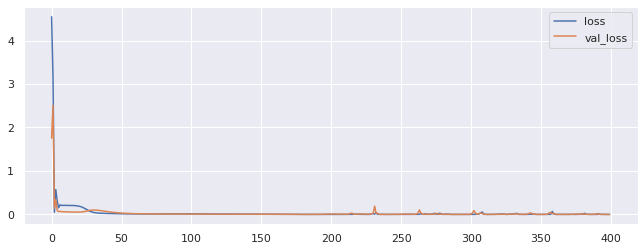

In [25]:
plt.plot(loss_values[:], label="loss")
plt.plot(val_loss_values[:], label="val_loss")
plt.legend()
plt.show()

In [26]:
mv_net.eval()
mv_net.init_hidden(testX.size(0))
test_predict = mv_net(testX).detach().numpy()

test_predict = target_scaler.inverse_transform(test_predict.reshape(-1, 1))

from sklearn.metrics import mean_squared_error
rmse = mean_squared_error(test_predict[:,0],daily_data_with_weather['Energy_Generated'].iloc[train_size + n_timesteps::1] ,squared=False)
print("RMSE = %d" % rmse) 

RMSE = 1651


(1976, 1)
(1976,)


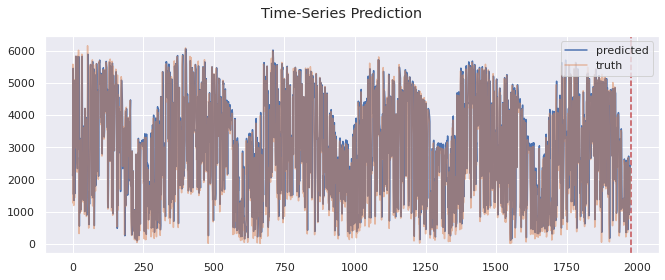

In [27]:
mv_net.init_hidden(trainX.size(0))
train_predict = mv_net(trainX)
train_predict = train_predict.data.numpy()
print(train_predict.shape)

train_truth = daily_data_with_weather['Energy_Generated'].iloc[90:train_size + 90:1]
print(train_truth.shape)
train_predict = target_scaler.inverse_transform(train_predict.reshape(-1,1))
plt.axvline(x=train_size, c='r', linestyle='--')

plt.plot(train_predict[:,0], label="predicted")
plt.plot(train_truth.values, alpha=0.5, label="truth")
plt.suptitle('Time-Series Prediction')
plt.legend()
plt.show()

<Figure size 792x288 with 0 Axes>

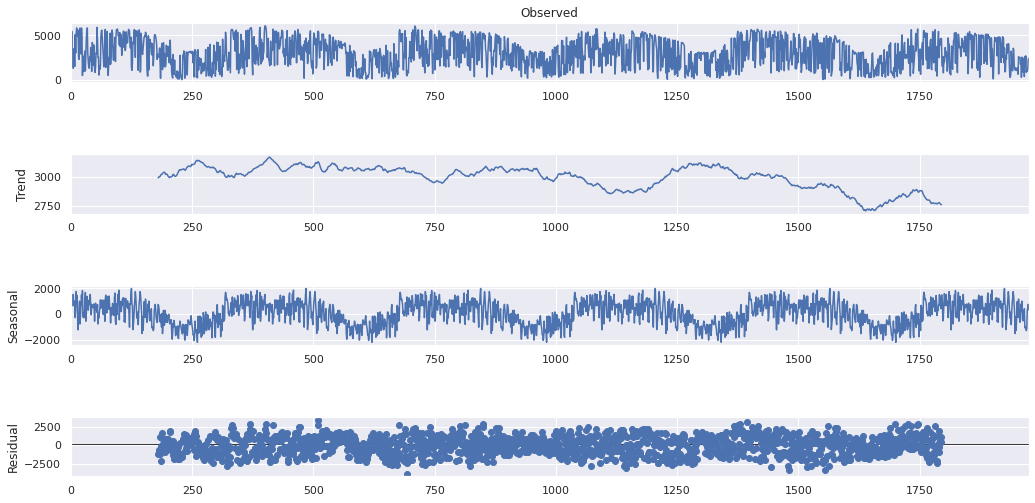

In [28]:
from statsmodels.tsa.seasonal import seasonal_decompose

decomposition = seasonal_decompose(train_predict[:,0],period=360) 

fig = plt.figure()  
fig = decomposition.plot()  
fig.set_size_inches(15, 8)

mean = 78.69163
std  = 1717.7937
74.54285
0.6548396640317085


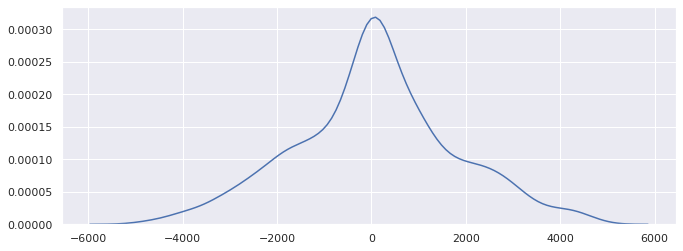

In [29]:
residuals = train_predict[:,0] - train_truth.values
sns.kdeplot(residuals)
print("mean =", np.mean(residuals))
print("std  =", np.std(residuals))
print(np.median(residuals))
from scipy import stats
k2, p  = stats.normaltest(residuals)
print(p)

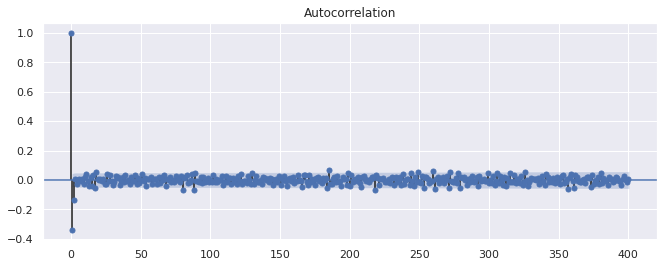

In [30]:
import statsmodels.api as sm
acf = sm.graphics.tsa.plot_acf(residuals, lags=400)

In [31]:
class QdLoss(nn.Module):
    def __init__(self, batch_size):
        super().__init__()
        self.lambda_ = 0.01 # lambda in loss fn
        self.alpha = 0.10  # capturing (1-alpha)% of samples
        self.soften = 150.
        self.n = batch_size
        
    def forward(self, preds, y_true):
        self.n = preds.size()[0]
        y_u = preds[:,1]
        y_l = preds[:,0]

        K_HU = torch.clamp(torch.sign(y_u - y_true), min=0.)
        K_HL = torch.clamp(torch.sign(y_true - y_l), min=0.)
        K_H  = torch.mul(K_HU, K_HL)

        K_SU = torch.sigmoid(self.soften * (y_u - y_true))
        K_SL = torch.sigmoid(self.soften * (y_true - y_l))
        K_S  = torch.mul(K_SU, K_SL)

        MPIW_c = torch.sum(torch.mul((y_u - y_l), K_H))/torch.sum(K_H)
        PICP_H = torch.mean(K_H)
        PICP_S = torch.mean(K_S)

        Loss_S = MPIW_c \
                + self.lambda_ * self.n / (self.alpha*(1-self.alpha)) \
                * torch.clamp((1-self.alpha) - PICP_S, min=0.)
        return Loss_S

In [32]:
input_size  = 1
nb_output = 2

bias_init_values = [y.astype(np.float64).min(), y.astype(np.float64).max()]
print(bias_init_values)
pi_mv_net = MV_LSTM(n_features,n_timesteps,nb_output,bias_init_values)
optimizer = torch.optim.Adam(pi_mv_net.parameters())#, lr=0.001)#,weight_decay=0.01)
criterion = QdLoss(batch_size)

[0.0, 0.9999999403953552]


In [33]:
pi_loss_values = []
pi_val_loss_values = []

for t in range(train_episodes):
    pi_mv_net.train()
    for b in range(0,len(trainX),batch_size):
        inpt = trainX[b:b+batch_size,:,:]
        target = trainY[b:b+batch_size]   

        x_batch = torch.tensor(inpt,dtype=torch.float32)    
        y_batch = torch.tensor(target,dtype=torch.float32)

        pi_mv_net.init_hidden(x_batch.size(0))
        output = pi_mv_net(x_batch) 
        loss = criterion(output, y_batch)  

        loss.backward()
        optimizer.step()        
        optimizer.zero_grad() 
    pi_loss_values.append(loss)
        
    ##add test
    pi_mv_net.eval()
    pi_mv_net.init_hidden(testX.size(0))
    test_predict = pi_mv_net(testX)
    loss = criterion(test_predict, testY)  
    pi_val_loss_values.append(loss)
    if t % 10 == 0:
        print("%d, loss %f val_loss %f" % (t,pi_loss_values[-1],loss)) 

0, loss 1.258386 val_loss 1.203195
10, loss 0.953034 val_loss 0.949260
20, loss 0.839527 val_loss 0.803047
30, loss 0.760205 val_loss 0.763273
40, loss 0.731528 val_loss 0.771139
50, loss 0.660720 val_loss 0.708851
60, loss 0.623930 val_loss 0.699991
70, loss 0.636774 val_loss 0.706821
80, loss 0.581180 val_loss 0.654727
90, loss 0.545207 val_loss 0.608526
100, loss 0.557034 val_loss 0.616968
110, loss 0.619237 val_loss 0.668514
120, loss 0.512293 val_loss 0.567784
130, loss 0.466189 val_loss 0.535936
140, loss 0.692455 val_loss 0.463494
150, loss 0.463577 val_loss 0.582113
160, loss 0.401115 val_loss 0.426778
170, loss 0.330084 val_loss 0.402013
180, loss 0.328771 val_loss 0.421812
190, loss 0.241893 val_loss 0.281338
200, loss 0.479443 val_loss 0.447788
210, loss 0.263308 val_loss 0.275769
220, loss 0.237926 val_loss 0.299954
230, loss 0.479902 val_loss 0.566378
240, loss 0.404230 val_loss 0.367893
250, loss 0.422038 val_loss 0.412800
260, loss 0.404272 val_loss 0.398405
270, loss 0.

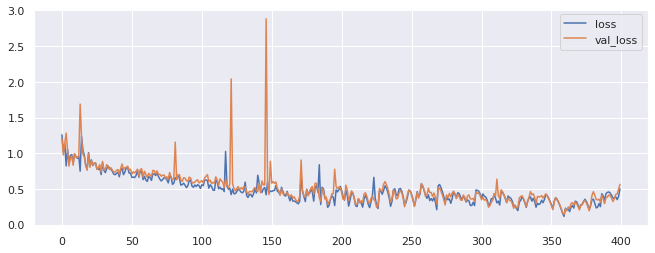

In [34]:
plt.plot(pi_loss_values[:], label="loss")
plt.plot(pi_val_loss_values[:], label="val_loss")
plt.legend()
plt.show()

In [35]:
#pi_mv_net.init_hidden(trainX.size(0))
#pi_predict = pi_mv_net(trainX)
tmp = Variable(torch.Tensor(X))
pi_mv_net.init_hidden(tmp.size(0))
pi_predict = pi_mv_net(tmp)

#### Plot prediction with prediction interval 

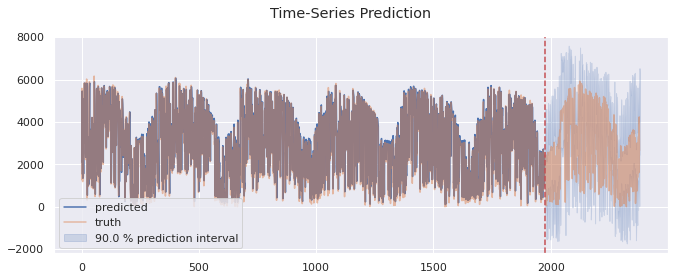

In [36]:
truth = daily_data_with_weather['Energy_Generated']

y_lower, y_upper = pi_predict[:, 0], pi_predict[:, 1]
data_lower = y_lower.data.numpy()
data_upper = y_upper.data.numpy()
data_lower = target_scaler.inverse_transform(data_lower.reshape(-1,1))
data_upper = target_scaler.inverse_transform(data_upper.reshape(-1,1))

pi_predict = pi_predict.data.numpy()


x = np.linspace(len(trainX), len(truth)-n_timesteps, len(testX))
plt.fill_between(x, data_upper[-len(testX):, 0],  data_lower[-len(testX):, 0], color='b', alpha=0.2,  label='{} % prediction interval'.format(100* (1-criterion.alpha)))
plt.plot(train_predict[:,0], label="predicted")
plt.plot(truth.values[n_timesteps:], alpha=0.5, label="truth")

plt.axvline(x=train_size, c='r', linestyle='--')


plt.suptitle('Time-Series Prediction')
plt.legend(loc='lower left')
plt.show()